# Method2 SVD+Huffman

## Import Libraries

In [1]:
import mne
import numpy as np
from scipy.fft import fft,fftshift
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
from scipy.signal import freqz
from scipy import signal
from sklearn.metrics import mean_squared_error
from math import sqrt
import os
import pandas as pd

In [2]:
ppg = pd.read_csv('BVP.csv')
np.savetxt('ppg.txt',ppg)
sampling_freq = 1/64  #This is the sampling frequency
ppg_array = ppg.to_numpy()
ppg_array = ppg_array[0:121000] #Cut the signal to get rid of the redundant part
N = ppg_array.size 
index = np.linspace(0, round((N-1)*sampling_freq,4), N)


## Butterworth Band pass Filter

In [3]:
from scipy.signal import butter, lfilter


def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

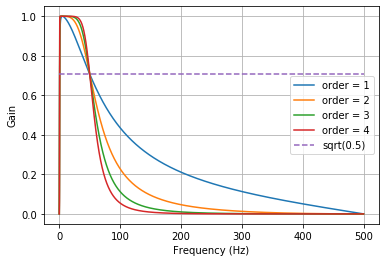

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz

# Sample rate and desired cutoff frequencies (in Hz).
fs = 1000.0
lowcut = 0.5
highcut = 50.0

# Plot the frequency response for a few different orders.
plt.figure(1)
plt.clf()
for order in [1, 2, 3, 4]:
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    w, h = freqz(b, a, worN=2000)
    plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
         '--', label='sqrt(0.5)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.legend(loc='best')

In [5]:
#Order = 2 is good in this case because the features will not be eliminated a lot(But higher order will)
y = butter_bandpass_filter(ppg_array, lowcut, highcut, fs, order=2)

## Resampling

For PPG, it's not so necessary to resample the signal because the sample frequency of the original signal is 64Hz. But in order to SVD, we need to approximate the signal into a squared number

In [6]:
resampled_signal = signal.resample(y,120409 )  
#This squared number need to be decided by the users

np.savetxt('processed_ppg.txt',resampled_signal)

## SVD -- Singular Value Decomposition

In [7]:
from scipy import linalg
reshaped_signal = np.reshape(resampled_signal, (347,347))
U, s, Vh = linalg.svd(reshaped_signal)
print(reshaped_signal.shape)
print(U.shape)
print(s.shape)
print(Vh.shape)

(347, 347)
(347, 347)
(347,)
(347, 347)


In [8]:
s[75:] = 0

In [9]:
m = 347
n = 347
sigma = np.zeros((m, n))
for i in range(min(m, n)):
    sigma[i, i] = s[i]
reconstructed_signal = np.dot(U, np.dot(sigma, Vh))
deSVD = np.reshape(reconstructed_signal,347*347)
np.savetxt('deSVD_ppg.txt',deSVD,fmt='%.6f')

## Huffman coding

### INSTRUCTION ON HOW TO COMPRESS THE DATA BY HUFFMAN CODING


(I used the package "tcmpr 0.2" and "pyhuff 1.1". These two packages provided the same compression result. So here, we just use "tcmpr 0.2")

1. Open your termial or git bash, enter "pip install tcmpr" to install the "tcmpr 0.2" package
2. Enter the directory which include the file you want to compress OR copy the path of the file you want to compress
3. Enter "tcmpr filename.txt" / "tcmpr filepath" to compress the file
4. Find the compressed file in the same directory of the original file

In [10]:
# Do Huffman encoding based on the instruction above 
# or run this trunk if this scratch locates in the same directory with the signal you want to encode
os.system('tcmpr deSVD_ppg.txt')

0

You could find a file name "deSVD_ppg.txt.huffman" in the current directory

### After this step, you could calculate the compression ratio if you want

## Decode the data

In [11]:
os.system('tcmpr -d deSVD_ppg.txt.huffman')
decoded_data = np.loadtxt(fname = "deSVD_ppg.txt")
decoded_data =decoded_data[..., np.newaxis]

In [12]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy import signal
# original_signal = normalized_signal
# compressed_signal = decoded_data
def PRD_calculation(original_signal, compressed_signal):
    PRD = sqrt(sum((original_signal-compressed_signal)**2)/(sum(original_signal**2)))
    return PRD

PRD = PRD_calculation(resampled_signal, decoded_data)
print("The PRD is {}%".format(round(PRD*100,3)))

The PRD is 1.747%


CR = 3.7*1024/400 = 9.47

## Plot and see the difference

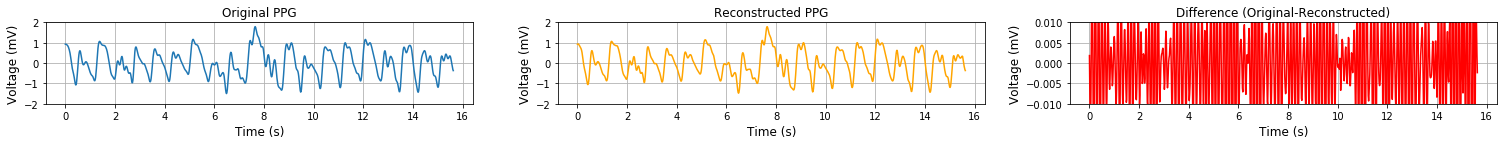

In [13]:

time_index = np.linspace(0,15.625,1000)
fig, ax = plt.subplots(1,3, figsize = (26,1.5))

ax[0].plot(time_index, resampled_signal[75000:76000], label = "origianl")
ax[0].grid()
ax[0].set_title("Original PPG")
ax[0].set_xlabel("Time (s)", size = 12)
ax[0].set_ylabel("Voltage (mV)", size = 12)
ax[0].set_ylim(-2,2)


ax[1].plot(time_index, decoded_data[75000:76000], label = "recovered", color = "orange")
ax[1].grid()
ax[1].set_title("Reconstructed PPG")
ax[1].set_xlabel("Time (s)", size = 12)
ax[1].set_ylabel("Voltage (mV)", size = 12)
ax[1].set_ylim(-2,2)

ax[2].plot(time_index,(resampled_signal[75000:76000]-decoded_data[75000:76000]), label = "Difference", color = "red")
ax[2].grid()
ax[2].set_title("Difference (Original-Reconstructed)")
ax[2].set_xlabel("Time (s)", size = 12)
ax[2].set_ylabel("Voltage (mV)", size = 12)
#ax[2].set_ylim(-2,2)
ax[2].set_ylim(-0.01,0.01)

plt.savefig('ppg_huffman.png',dpi=300,bbox_inches = "tight")


In [14]:
rec = decoded_data[75000:76000]
ori = resampled_signal[75000:76000]
np.savetxt('x_ppg.txt',time_index)
np.savetxt("rec_ppg.txt",rec)
np.savetxt("ori_ppg.txt",ori)

### Instructions

Put instructions of how to use your method here.

More instruction needs to be well documented

Dependencies: 

All codes based on Python3
Numpy, Pandas, tcmpr 0.2 installed on the users' system